In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

import json
import gc

from scipy.stats import uniform

import warnings
warnings.filterwarnings("ignore")

In [8]:
def load_csv(csv_path, nrows=None, skiprows=None):
    json_cols = ['device', 'geoNetwork', 'totals', 'trafficSource']
    df = pd.read_csv(csv_path,
                     converters = {col: json.loads for col in json_cols},
                     dtype={'fullVisitorId': 'str'},
                     nrows=nrows,
                     skiprows=skiprows)
    
    for col in json_cols:
        normalized_col_df = pd.json_normalize(df[col])
        df = pd.concat([df.drop(columns=col), normalized_col_df], axis=1)
    return df

In [4]:

df = pd.read_csv('./dataset/train.csv')
df.size

/tmp/ipykernel_93067/946386692.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./dataset/train.csv')


10843836

In [33]:
train_df = load_csv('./dataset/train.csv', nrows=10000)

In [34]:
train_df.size

540000

In [24]:

# Python program to read CSV file line by line
# import necessary packages
import csv
  
# Open file 
with open('./dataset/train.csv') as file_obj:
      
    # Create reader object by passing the file 
    # object to reader method
    reader_obj = csv.reader(file_obj)
      
    # Iterate over each row in the csv 
    # file using reader object
    i=0
    for row in reader_obj:
        print(row)
        if i==5:
            break
        i+=1    

['channelGrouping', 'date', 'device', 'fullVisitorId', 'geoNetwork', 'sessionId', 'socialEngagementType', 'totals', 'trafficSource', 'visitId', 'visitNumber', 'visitStartTime']
['Organic Search', '20160902', '{"browser": "Chrome", "browserVersion": "not available in demo dataset", "browserSize": "not available in demo dataset", "operatingSystem": "Windows", "operatingSystemVersion": "not available in demo dataset", "isMobile": false, "mobileDeviceBranding": "not available in demo dataset", "mobileDeviceModel": "not available in demo dataset", "mobileInputSelector": "not available in demo dataset", "mobileDeviceInfo": "not available in demo dataset", "mobileDeviceMarketingName": "not available in demo dataset", "flashVersion": "not available in demo dataset", "language": "not available in demo dataset", "screenColors": "not available in demo dataset", "screenResolution": "not available in demo dataset", "deviceCategory": "desktop"}', '1131660440785968503', '{"continent": "Asia", "subCon

In [35]:
def clean_up(df, train=False, valid=False):
    if train or valid:
        df = df.drop(columns='transactionRevenue') # This field is deprecated. Use "totals.totalTransactionRevenue" instead
        df["totalTransactionRevenue"] = df['totalTransactionRevenue'].fillna("0").astype(float)
    
    df["pageviews"] = df["pageviews"].fillna(0).astype(int)
    df["newVisits"] = df["newVisits"].fillna(0).astype(int)
    df["sessionQualityDim"] = df["sessionQualityDim"].fillna("1").astype(int)
    return df

train_df = clean_up(train_df, train=True)

KeyError: 'totalTransactionRevenue'

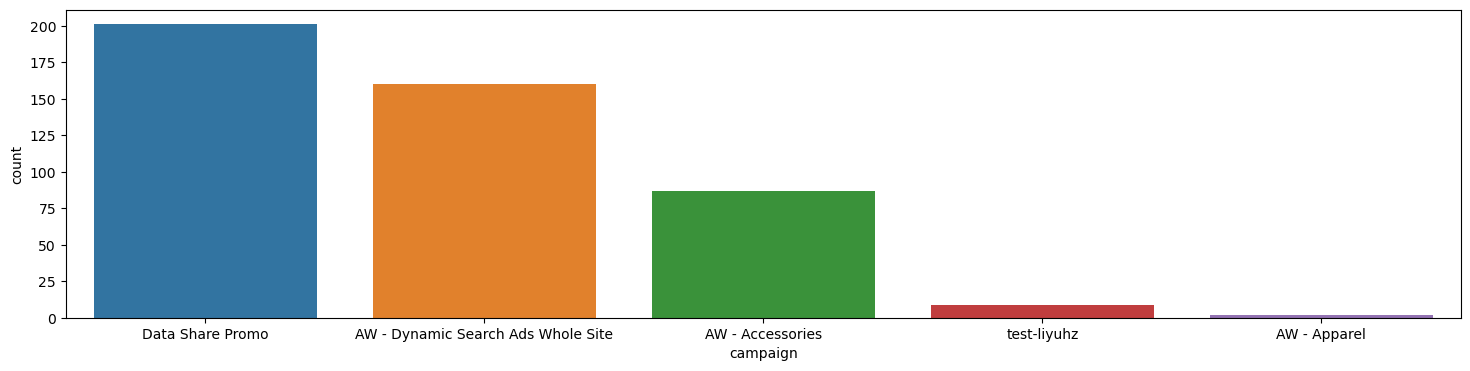

In [36]:
country_counts = train_df[["campaign"]].groupby("campaign").size().sort_values(ascending=False)[1:6]
country_counts = country_counts.reset_index()
country_counts.columns = ["campaign", "count"]

plt.figure(figsize=(18,4))
sns.barplot(data=country_counts, x="campaign", y="count")
plt.show()

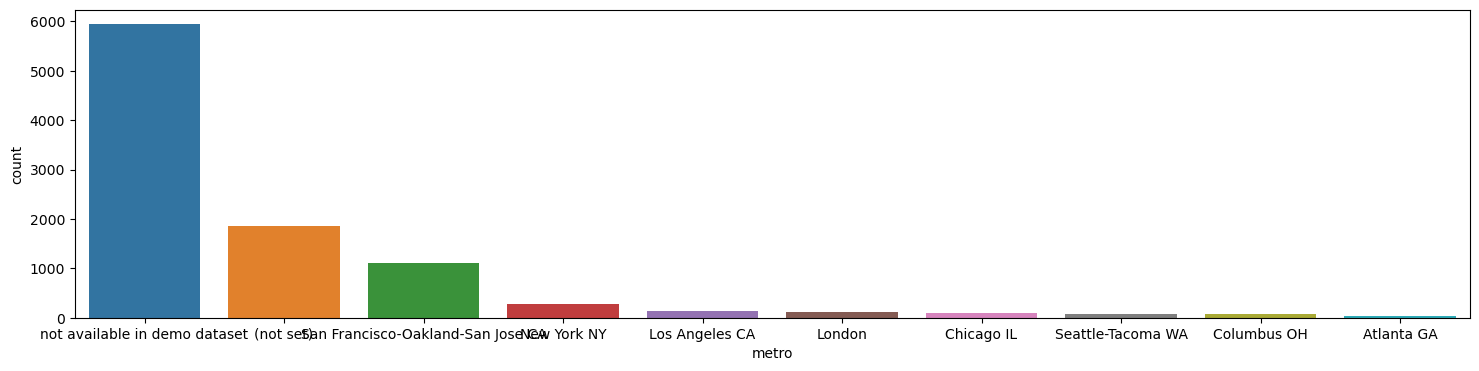

In [37]:
country_counts = train_df[["metro"]].groupby("metro").size().sort_values(ascending=False)[:10]
country_counts = country_counts.reset_index()
country_counts.columns = ["metro", "count"]

plt.figure(figsize=(18,4))
sns.barplot(data=country_counts, x="metro", y="count")
plt.show()

In [38]:
top_countries = train_df[["country"]].groupby("country").size().sort_values(ascending=False)[:20].index.to_numpy()
train_df_top_countries = train_df[train_df["country"].isin(top_countries)]

plt.figure(figsize=(18,4))
sns.stripplot(data=train_df_top_countries, x="country", y="totalTransactionRevenue")
plt.show()

ValueError: Could not interpret input 'totalTransactionRevenue'

<Figure size 1800x400 with 0 Axes>

In [39]:
def feature_extraction(df):
    agg_df = df.groupby("fullVisitorId")["newVisits", "pageviews"].agg(
        newVisits_sum = ("newVisits", "sum"),
        pageviews_sum = ("pageviews", "sum"),
        pageviews_mean = ("pageviews", "mean"),
        pageviews_std = ("pageviews", "std"),
    ).reset_index()
    agg_df["pageviews_std"] = agg_df["pageviews_std"].fillna(0)
    df = pd.merge(df, agg_df, on="fullVisitorId", suffixes=("", ""))
    return df

train_df = feature_extraction(train_df)

In [40]:
plt.figure(figsize=(18,4))
sns.stripplot(data=train_df, x="pageviews_std", y="totalTransactionRevenue")
plt.show()

ValueError: Could not interpret input 'totalTransactionRevenue'

<Figure size 1800x400 with 0 Axes>

In [41]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 58 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   channelGrouping                      10000 non-null  object 
 1   date                                 10000 non-null  int64  
 2   fullVisitorId                        10000 non-null  object 
 3   sessionId                            10000 non-null  object 
 4   socialEngagementType                 10000 non-null  object 
 5   visitId                              10000 non-null  int64  
 6   visitNumber                          10000 non-null  int64  
 7   visitStartTime                       10000 non-null  int64  
 8   browser                              10000 non-null  object 
 9   browserVersion                       10000 non-null  object 
 10  browserSize                          10000 non-null  object 
 11  operatingSystem              